In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def load_img(file_path):
  max_dim = 512
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Tweak shape so the maximum dimension is 512px.
  # This is the max shape that VGG19 expects.
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  longer_dim = max(shape)
  scale = max_dim / longer_dim
  # Scale shape according to the size of the larger dim.
  rescaled = tf.cast(shape * scale, tf.int32)
  # Resize the image with rescaled shape.
  img = tf.image.resize(img, rescaled)
  # Expand the dimension as this is what the model expects.
  # [B, I, J, C]
  img = tf.expand_dims(img, axis=0)
  return img

In [0]:
content = load_img('royalholloway.jpeg')
style = load_img('starrynight.jpg')

Text(0.5, 1.0, 'Style Image')

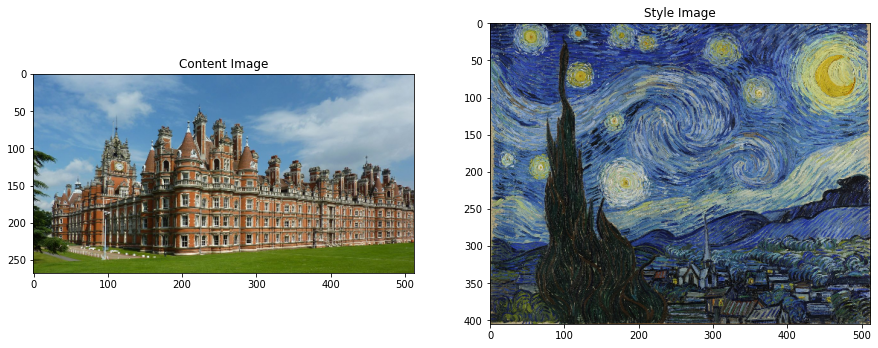

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(tf.squeeze(content, 0))
axs[0].set_title("Content Image")
axs[1].imshow(tf.squeeze(style, 0))
axs[1].set_title("Style Image")

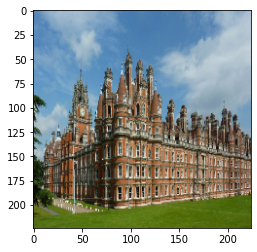

In [70]:
plt.imshow(tf.image.resize(tf.squeeze(content, 0), [224, 224]))

In [0]:
# Break out the VGG19 network.
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [0]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def transfer_vgg(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)

  return model
  

In [0]:
# The style of an image can be illustrated by the correlation across different
# filters.
def gram_matrix(t):
  result = tf.einsum('bijc, bijd->bcd', t, t)
  shape = tf.shape(t)
  # num loc is the area of pixels on the image.
  num_loc = tf.cast(shape[1]*shape[2], tf.float32)
  return result/(num_loc)

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = transfer_vgg(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


In [0]:
style_content_model = StyleContentModel(style_layers, content_layers)

In [0]:
style_targets = style_content_model(style)['style']
content_targets = style_content_model(content)['content']

In [0]:
image = tf.Variable(content)

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
optimiser = tf.optimizers.Adam(learning_rate=0.02)

In [0]:
style_weight = 1e-2
content_weight = 1e3

In [0]:
def mse(y, y_hat):
  return tf.reduce_mean((y - y_hat) ** 2)

In [0]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([mse(style_outputs[name], style_targets[name]) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([mse(content_outputs[name], content_targets[name]) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [0]:
import IPython.display as display
import PIL.Image as pil

In [0]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return pil.fromarray(tensor)

In [0]:
total_variation_weight = 30

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = style_content_model(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  optimiser.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [0]:
image = tf.Variable(content)

In [0]:
!pip install -q imageio

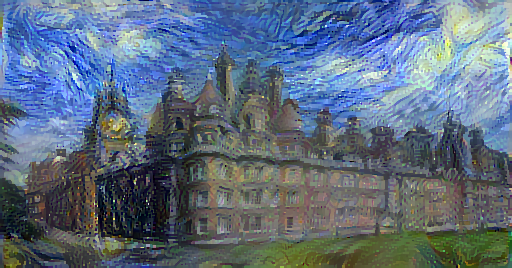

In [91]:
import time
epochs = 20
steps_per_epoch = 100

images = []

step = 0
for n in range(epochs):
  print(f"Epoch {n+1}: ", end='')
  for m in range(steps_per_epoch):
    step += 1
    images.append(tensor_to_image(image))
    train_step(image)
    print(".", end='')
    
  display.clear_output()

    # tensor_to_image(image).save(f"image-{step+(steps_per_epoch*epochs)}.jpeg".
images.append(tensor_to_image(image))
display.display(tensor_to_image(image))

In [0]:
for i, img in enumerate(images):
  img.save(f"f/image-{i}.jpeg")

In [0]:
import imageio
import glob
anim_file = 'royalholloway.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('f/image*.jpeg')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)